In [2]:
!pip3 install gym
!pip3 install tensorflow
!pip3 install box2d-py

     |████████████████████████████████| 450kB 2.8MB/s 


In [3]:
import gym
import numpy as np
import random
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
def train_model(env, n_inputs, n_outputs, n_max_steps, model, batch_size, discount_rate, random_proba = 1):
  iter_num_to_check_stop = 100
  scores = np.array([])
  memory = {"state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
            }

  for iteration in range(n_iterations):

    if iteration == iter_num_to_check_stop:
      last_negative_reward_index = np.argwhere(scores<0)[-1]
      positive_tail_length = iteration - last_negative_reward_index
      if positive_tail_length >= 100:
        break
      else:
        iter_num_to_check_stop = last_negative_reward_index + 100

    obs = env.reset()  
    obs = obs.reshape([1,n_inputs])

    game_score = 0
    for step in range(n_max_steps):       
      # get action:
      if np.random.rand() <= random_proba:
        action = int(random.randrange(n_outputs))
      else:
        logits = model(obs)
        action = int(np.argmax(logits[0]))

      # make action:
      new_obs, reward, done, info = env.step(action)
      new_obs = new_obs.reshape([1,n_inputs])

      # update history:
      game_score += reward   

      if len(memory["state"])>0:
          memory["state"] = np.vstack((memory["state"], obs))
          memory["new_state"] = np.vstack((memory["new_state"], new_obs))
      else:
          memory["state"] = np.array(obs)
          memory["new_state"] = np.array(new_obs)
      memory["action"] = np.append(memory["action"], action)
      memory["reward"] = np.append(memory["reward"], reward)
      memory["done"] = np.append(memory["done"], done)

      obs = new_obs

      # experience replay:
      if len(memory["state"])>=batch_size:
        # get batch
        idxs = np.random.randint(len(memory["done"]), size=batch_size)
        batch = {
            "state": np.squeeze(memory["state"][idxs]), 
            "action": memory["action"][idxs], 
            "reward": memory["reward"][idxs], 
            "new_state": np.squeeze(memory["new_state"][idxs]), 
            "done": memory["done"][idxs]
        }
        # get loss:
        q_values = batch["reward"] + \
              discount_rate*(np.amax(model.predict_on_batch(batch["new_state"]), axis=1))*(1-batch["done"])
        network_training = model.predict_on_batch(batch["state"])
        network_training[np.array(range(batch_size)), batch["action"]] = q_values

        # update model:
        model.fit(batch["state"], network_training, epochs = 1, verbose = 0)
        if random_proba > 0.01:
          random_proba *= 0.99

      if done:
        break

    scores = np.append(scores, game_score)
    if (iteration+1) % 100 == 0:
      print('Avg score for the last {} games: {}'.format(100, np.mean(scores[-100:])))
  print("Evaluate in {} iterations".format(iteration+1))
  return scores, model

In [0]:
def model_build(input_size, output_size):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(128, input_dim = input_size, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(output_size, activation = "linear"))
  model.compile(loss='mse', optimizer="Adam")
  return model

In [6]:
n_iterations = 1000
discount_rate = 0.99
batch_size = 64

env = gym.make('LunarLander-v2')
n_inputs = env.observation_space.shape[0]
n_outputs = 4
n_max_steps = 1000

model = model_build(n_inputs, n_outputs)

scores, trained_model = train_model(env, n_inputs, n_outputs, n_max_steps, model, batch_size, discount_rate)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Avg score for the last 100 games: -7.524522968635267
Avg score for the last 100 games: 191.34663309269644
Avg score for the last 100 games: 210.0681101431629
Avg score for the last 100 games: 245.0544096549823
Avg score for the last 100 games: 248.41917070058633
Avg score for the last 100 games: 232.80952724434738
Avg score for the last 100 games: 246.2268044290002
Avg score for the last 100 games: 250.6331719829782
Avg score for the last 100 games: 240.51466290472473
Avg score for the last 100 games: 252.8849931666696
Evaluate in 1000 iterations


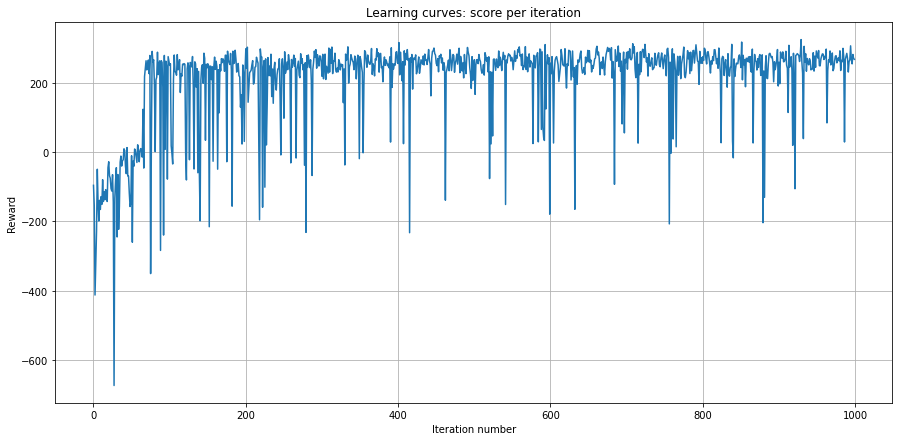

In [7]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")

plt.show()

In [0]:
test_games = 100

test_scores = []
for game_index in range(test_games):
  score = 0
  obs = env.reset()
  for step in range(n_max_steps): 
    obs = obs.reshape([1,n_inputs])
    logits = trained_model(obs)
    action = int(np.argmax(logits[0]))
    obs, reward, done, info = env.step(action)
    score += reward
    if done:
      break
  test_scores.append(score)

In [9]:
print("Average reward on test 100 games: ", np.mean(test_scores))

Average reward on test 100 games:  169.62030223027406


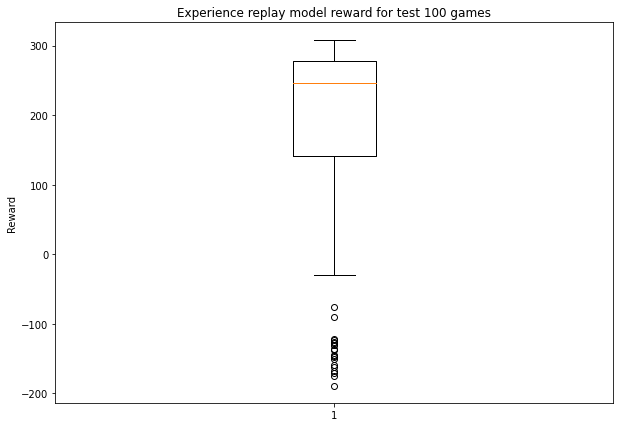

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Experience replay model reward for test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.show()

In [0]:
trained_model.save('my_model.h5')
